In [82]:
import pandas_datareader as pdr
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Collecting Data

In [83]:
startdate = datetime.datetime(2000, 10, 1)
enddate = datetime.datetime(2020, 5, 7)
predictdate = datetime.datetime(2018,11,22)
predictdate = datetime.datetime(2019,11,22)

#SIGN = ['AAPL','GOOGL','MSFT','AMZN']
#SIGN = ['AC','AI','AIR']
SIGN = ['AIR']
TRAINSIGN = 'AIR'

ticker = pdr.get_data_yahoo(SIGN, start=startdate, end=enddate)

Attributes  Adj Close      Close       High        Low       Open    Volume
Symbols           AIR        AIR        AIR        AIR        AIR       AIR
Date                                                                       
2020-05-01  18.330000  18.330000  19.219999  17.629999  19.020000  364500.0
2020-05-04  17.969999  17.969999  18.290001  17.270000  17.510000  447100.0
2020-05-05  17.590000  17.590000  18.980000  17.400000  18.490000  304200.0
2020-05-06  16.340000  16.340000  17.790001  16.299999  17.620001  244200.0
2020-05-07  16.690001  16.690001  17.490000  16.549999  16.620001  378700.0

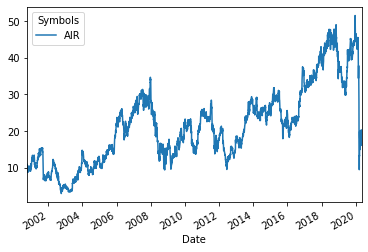

In [84]:
ticker['Adj Close'].plot()
ticker.tail()

# Basic analysis

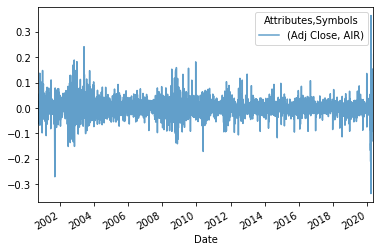

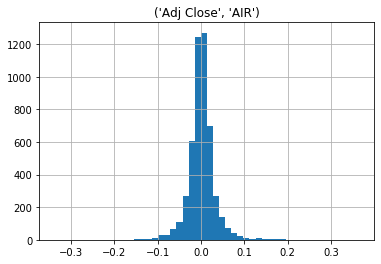

In [85]:
#Returns
daily_close_px = ticker[['Adj Close']]
daily_pct_change = daily_close_px.pct_change()

# Show retrun and distribution
daily_pct_change.plot(alpha=0.7)
daily_pct_change.hist(bins=50, sharex=True)

plt.show()

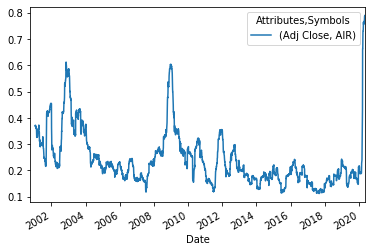

In [86]:
#Volatility
min_periods = 75

# Calculate the volatility
vol = daily_pct_change.rolling(min_periods).std() * np.sqrt(min_periods) 
vol.plot()

# Algorithms to predict stocks

In [87]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb 19 16:05:16 2020

@authors: alanloret, alexandretaranoff, axelchedri, alexisaubert
"""

# import packages
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import datetime

# machine learning packages
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor

# measure results
from sklearn.metrics import mean_squared_error

""" Useful functions """


class PossibleDataLeakages(Exception):
    """ This error class is raised when you input a date that may lead to data leakages :
        when you want to make predictions on the training data with a start date earlier
        than the end date of training dataset """
    pass


def my_data(start, end, share, days=0):
    """ Collecting our data from Yahoo website and returns a dataframe
        with the data from the start date to the end date.
        Note : here we collect our date futher than the input dates because due to moving average and rsi features
        if we don't do this NaN values will appear in our data. Moreover we have to be careful with the closing days."""

    data = web.DataReader(share, 'yahoo', datetime.datetime(*start) - datetime.timedelta(days=days),
                          datetime.datetime(*end)+datetime.timedelta(days=4)).rename(columns={'Adj Close': 'Adj_Close'})

    return data


def collect_data(start, end, *shares, **kwargs):
    """ Collecting our data and creating the features we want.
        Note :
        start -> tuple with (yyyy, mm, dd)
        shares -> strings made of shares name
        kwargs -> you can input * 'depths' for different depths for moving average and rsi features """

    stocks = {}
    depths = kwargs.get('depths', [14, 18, 30])

    for share in shares:
        df_share = my_data(start, end, share, 2*max(depths) + 1)
        df_share = df_share.sort_index()
        data = df_share.copy()

        # Crating our features
        data['1d_MinMax'] = data.High - data.Low
        data['1d_diff'] = data.Open - data.Close
        data['returns'] = data.Close.pct_change()
        data['change'] = data.Close.diff()
        data['gain'] = data.change.mask(data.change < 0, 0.0)
        data['loss'] = -data.change.mask(data.change > 0, -0.0)
        data['3d_pct'] = data.Close.pct_change(3)
        for depth in depths:
            data['ma' + str(depth)] = data.Close.rolling(depth).mean()
            data['rsi' + str(depth)] = 100 - 100/(1 + data.gain.rolling(depth).mean()/data.loss.rolling(depth).mean())

        # Target
        data['target'] = data['change'].shift(-1)

        # Drop all NaN values and select the useful data
        data.dropna(axis=0, inplace=True)
        data = data[datetime.datetime(*start) <= data.index]
        stocks[share] = data[datetime.datetime(*end) >= data.index].copy()

    return stocks


def linear_regression(start, end, *shares, **kwargs):
    """ Does a Linear Regression of the stocks and predicts the share's value for the date you've input
        Notes :
        start/end -> tuples with (yyyy, mm, dd)
        shares -> strings made of shares name
        kwargs -> you can input * 'features' for the training data,
                                * 'depths' for different depths for moving average and rsi features
                                * 'training_share' to select the share you want to train with """

    predictions = {}

    depths = kwargs.get('depths', [14, 18, 30])

    # Select the best features for the linear regression
    best_features = ['Low', 'Close', 'change', 'returns', 'gain', 'loss'] + ['rsi'+str(d) for d in depths] + ['target']
    features = kwargs.get('features', best_features)

    # Train-test split
    training_share = kwargs.get('training_share', TRAINSIGN)
    train = collect_data((2009, 1, 1), (2017, 10, 26), training_share, **kwargs)[training_share]
    train_data = train[features].copy()
    X_train, y_train = train_data.loc[:, train_data.columns != 'target'], train_data.target

    # Define the model
    model = LinearRegression()

    # Train the model using the training sets
    model.fit(X_train, y_train)

    for stock, df_stock in collect_data(start, end, *shares, **kwargs).items():
        if datetime.datetime(2017, 10, 26) > datetime.datetime(*start) and stock == training_share:
            raise PossibleDataLeakages('Your start date prediction is before the end date of the training data'
                                       'for the training share')

        df = df_stock[features].copy()
        X_test, y_test = df.loc[:, df.columns != 'target'], df.target

        # Make predictions
        y_pred_test = model.predict(X_test)
        y_pred_test = pd.Series(y_pred_test, index=y_test.index)

        predictions[stock] = pd.DataFrame(y_pred_test + df_stock.Close, columns=['target'])
        predictions[stock + '_mse'] = np.sqrt(mean_squared_error(y_pred_test, y_test))

    return predictions


my_pred = linear_regression((2018, 11, 27), (2020, 1, 1), 'AAPL', training_share='AAPL', depths=[13, 18, 30])


def random_decision_tree(start, end, *shares, **kwargs):
    """ Creates a random tree regressor on the stocks to predict the share's value for the date you've input
        Notes :
        start/end -> tuples with (yyyy, mm, dd)
        shares -> strings made of shares name
        kwargs -> you can input * 'features' for the training data,
                                * 'depths' for different depths for moving average and rsi features
                                * 'training_share' to select the share you want to train with """

    predictions = {}

    depths = kwargs.get('depths', [14, 18, 30])

    # Select the best features for the random tree regressor
    best_features = ['ma' + str(d) for d in depths[1:]] + ['rsi' + str(d) for d in depths] +\
                    ['1d_MinMax', '1d_diff', 'gain', 'loss', 'returns', 'target']
    features = kwargs.get('features', best_features)

    #^FCHI
    # Train-test split
    training_share = kwargs.get('training_share', TRAINSIGN)
    train = collect_data((2009, 1, 1), (2017, 10, 26), training_share, **kwargs)[training_share]
    train_data = train[features].copy()
    X_train, y_train = train_data.loc[:, train_data.columns != 'target'], train_data.target

    # Define the model
    model = ExtraTreesRegressor(max_depth=9, random_state=0)

    # Train the model using the training sets
    model.fit(X_train, y_train)

    for stock, df_stock in collect_data(start, end, *shares, **kwargs).items():
        if datetime.datetime(2017, 10, 26) > datetime.datetime(*start) and stock == training_share:
            raise PossibleDataLeakages('Your start date prediction is before the end date of the training data '
                                       'for the training share')

        df = df_stock[features].copy()
        X_test, y_test = df.loc[:, df.columns != 'target'], df.target

        # Make predictions
        y_pred_test = model.predict(X_test)
        y_pred_test = pd.Series(y_pred_test, index=y_test.index)

        predictions[stock] = pd.DataFrame(y_pred_test + df_stock.Close, columns=['target'])
        predictions[stock + '_mse'] = np.sqrt(mean_squared_error(y_pred_test, y_test))

    return predictions


my_pred_2 = random_decision_tree((2018, 11, 27), (2020, 1, 1), '^FCHI', 'AAPL', features=['Low', 'target'])


def moving_average(start, end, *shares, **kwargs):
    """ This function uses moving average to predict the share's value for the date you've input
        Notes :
        start/end -> tuples with (yyyy, mm, dd)
        shares -> strings made of shares name
        kwargs -> you can input * 'depths' number of days for the moving average """

    predictions = {}

    depths = kwargs.get('depths', [14, 18, 30])
    features = ['ma' + str(depth) for depth in depths]

    for stock, df_stock in collect_data(start, end, *shares, **kwargs).items():
        df = df_stock[features].copy()
        for feature in features:
            predictions[stock + '_' + feature] = pd.DataFrame(df[feature], index=df[feature].index)\
                                                   .rename(columns={feature: 'target'})

    return predictions


#my_pred_3 = moving_average((2018, 11, 22), (2020, 1, 1), '^FCHI', depths=[1, 2])

D:\Programmes\Anaconda2019\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [88]:
#Create Data Frame
multiindex = [(a,b) for a in ['signal','Close','prediction','positions'] for b in SIGN]
signals = pd.DataFrame(index=ticker.index,columns=pd.MultiIndex.from_tuples(multiindex,names=['Attributes', 'Symbols']))

signals['signal'] = 0.0

pred = random_decision_tree((2018, 11, 22), (2020, 5, 7), *SIGN, depths=[1, 2])
#pred = linear_regression((2018, 11, 27), (2020, 1, 1), *SIGN, training_share=TRAINSIGN, depths=[13, 18, 30])

for sign in SIGN:
    signals.loc[:,('prediction',sign)] = pred[sign]['target']
    signals.loc[:,('Close',sign)] = ticker['Close'][sign]
    
# Create signals
short_window = 0
signals.loc[short_window:,'signal'] = np.where(signals['Close'][short_window:] 
                                            < signals['prediction'][short_window:], 1.0, 0.0)   

signals['positions'] = signals['signal'].diff()

signals.tail()

D:\Programmes\Anaconda2019\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Attributes signal      Close prediction positions
Symbols       AIR        AIR        AIR       AIR
Date                                             
2020-05-01    1.0  18.330000  18.504339       0.0
2020-05-04    0.0  17.969999  17.914126      -1.0
2020-05-05    1.0  17.590000  17.606923       1.0
2020-05-06    1.0  16.340000  16.683752       0.0
2020-05-07    1.0  16.690001  16.760278       0.0

# Show signals

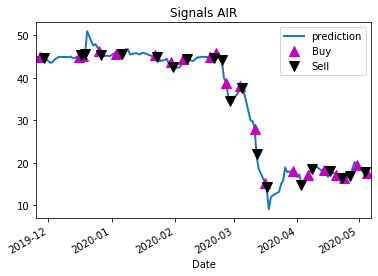

In [89]:
  # Initialize the plot figure
#fig = plt.figure()

# Add a subplot and label for y-axis
#ax1 = fig.add_subplot(111,  ylabel='Price in $')

#print(ticker['Close'][sign])

for sign in SIGN:
    plt.figure()
    # Plot the closing price
    #ticker['Close'][sign][ticker.index > predictdate].plot(color='r', lw=2.,label=sign)

    # Plot the short and long moving averages
    signals['prediction'][sign][ticker.index > predictdate].plot(lw=2.,label='prediction')
    
    #Plot the buy signals
    plt.plot(signals.loc[signals.positions[sign] == 1.0].index, 
         signals.Close[sign][signals.positions[sign] == 1.0],
         '^', markersize=10, color='m',label="Buy")
    
    #plot the sell signals
    plt.plot(signals.loc[signals.positions[sign] == -1.0].index, 
         signals.Close[sign][signals.positions[sign] == -1.0],
         'v', markersize=10, color='k',label="Sell")
    
    plt.legend()
    plt.title("Signals "+sign)

# Backtest

In [90]:
# Create a DataFrame `positions`
multiindex = [(a,b) for a in ['action','holdings','cash','total','returns'] for b in SIGN]
#positions = pd.DataFrame(index=signals.index).fillna(0.0)
portfolio = pd.DataFrame(index=signals.index,columns=pd.MultiIndex.from_tuples(multiindex,names=['Attributes', 'Symbols']))

for sign in SIGN:
    # Set the initial capital
    initial_capital= float(100000.0)
    
    positions = pd.DataFrame(index=signals.index,columns=['action']).fillna(0.0)

    # Buy a 100 shares
    positions['action'] = 100*signals['signal',sign]  
  
    # Initialize the portfolio with value owned   
    portfolio['action',sign] = positions['action'].multiply(ticker['Adj Close'][sign], axis=0)

    # Store the difference in shares owned 
    pos_diff = positions.diff()

    # Add `holdings` to portfolio
    portfolio['holdings',sign] = (positions['action'].multiply(ticker['Adj Close',sign], axis=0))#.sum(axis=1)

    # Add `cash` to portfolio
    portfolio['cash',sign] = initial_capital - (pos_diff.multiply(ticker['Adj Close',sign], axis=0)).sum(axis=1).cumsum()   

    # Add `total` to portfolio
    portfolio['total',sign] = portfolio['cash',sign] + portfolio['holdings',sign]

    # Add `returns` to portfolio
    portfolio['returns',sign] = portfolio['total',sign].pct_change()

# Print the first lines of `portfolio`
portfolio.tail()

Attributes       action     holdings          cash         total   returns
Symbols             AIR          AIR           AIR           AIR       AIR
Date                                                                      
2020-05-01  1832.999992  1832.999992  96429.829597  98262.829590 -0.001270
2020-05-04     0.000000     0.000000  98226.829529  98226.829529 -0.000366
2020-05-05  1759.000015  1759.000015  96467.829514  98226.829529  0.000000
2020-05-06  1634.000015  1634.000015  96467.829514  98101.829529 -0.001273
2020-05-07  1669.000053  1669.000053  96467.829514  98136.829567  0.000357

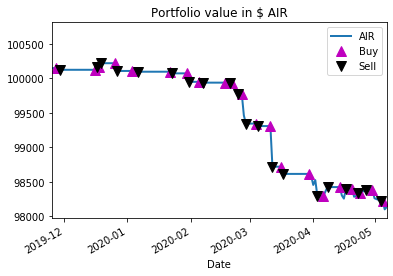

In [91]:
#print(signals[signals.index >= datetime.datetime(2020, 1, 7)])

for sign in SIGN:
    plt.figure()
   
    # Plot the equity curve in dollars
    portfolio['total'][sign][ticker.index > predictdate].plot(lw=2.)

    
    #Plot the buy signals
    plt.plot(portfolio.loc[signals.positions[sign] == 1.0].index, 
         portfolio['total'][sign][signals.positions[sign] == 1.0],
         '^', markersize=10, color='m',label="Buy")
    
    #plot the sell signals
    plt.plot(portfolio.loc[signals.positions[sign] == -1.0].index, 
         portfolio['total',sign][signals.positions[sign] == -1.0],
         'v', markersize=10, color='k',label="Sell")
    
    plt.legend()
    plt.title("Portfolio value in $ "+sign)



# Get indicators

In [92]:
#Total return
print((portfolio['total'].tail(1)-initial_capital)/initial_capital)

#Compare to basic buy and hold strategy

Symbols          AIR
Date                
2020-05-07 -0.018632


In [93]:
# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print("Sharpe ratio:",sharpe_ratio)

Sharpe ratio: Symbols
AIR   -0.376369
dtype: float64


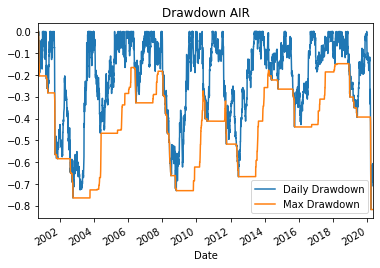

In [94]:
# Define a trailing 252 trading day window
window = 252

for sign in SIGN:
    plt.figure()
    # Calculate the max drawdown in the past window days for each day 
    rolling_max = ticker['Adj Close',sign].rolling(window, min_periods=1).max()
    daily_drawdown = ticker['Adj Close',sign]/rolling_max - 1.0

    # Calculate the minimum (negative) daily drawdown
    max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

    # Plot the results
    daily_drawdown.plot(label='Daily Drawdown')
    max_daily_drawdown.plot(label='Max Drawdown')
    
    plt.title("Drawdown "+sign)
    plt.legend()
    
    # Show the plot
    plt.show()

# Buy and hold

Symbols          AIR
Date                
2020-05-07 -0.027221
Sharpe ratio: Symbols
AIR   -0.351431
dtype: float64


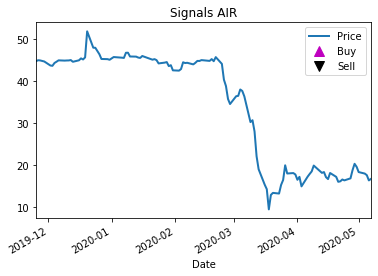

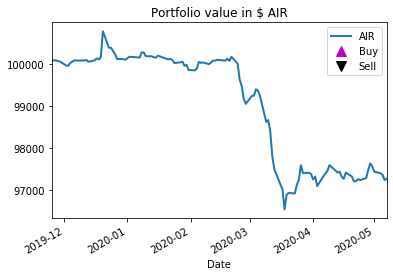

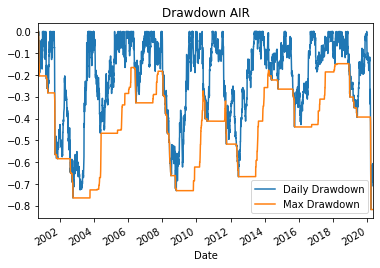

In [95]:
#Create Data Frame
multiindex = [(a,b) for a in ['signal','positions'] for b in SIGN]
signals = pd.DataFrame(index=ticker.index,columns=pd.MultiIndex.from_tuples(multiindex,names=['Attributes', 'Symbols']))

signals['signal'] = 0.0
signals['positions'] = 1.0

#print(signals.head())

# Detect if NAN
signals['nan'] = ticker['Close'].isnull()

# Create signals
signals['signal'] = np.where(signals.index >= predictdate, 1.0, 0.0)   

signals['positions'] = signals['signal'].diff()


# Print `signals`
signals.tail()

for sign in SIGN:
    plt.figure()
    # Plot the closing price
    #ticker['Close'][sign][ticker.index > predictdate].plot(color='r', lw=2.,label=sign)

    # Plot the short and long moving averages
    ticker['Close'][sign][ticker.index > predictdate].plot(lw=2.,label='Price')
    
    #Plot the buy signals
    plt.plot(signals.loc[signals.positions[sign] == 1.0].index, 
         ticker.Close[sign][signals.positions[sign] == 1.0],
         '^', markersize=10, color='m',label="Buy")
    
    #plot the sell signals
    plt.plot(signals.loc[signals.positions[sign] == -1.0].index, 
         ticker.Close[sign][signals.positions[sign] == -1.0],
         'v', markersize=10, color='k',label="Sell")
    
    plt.legend()
    plt.title("Signals "+sign)
    
multiindex = [(a,b) for a in ['action','holdings','cash','total','returns'] for b in SIGN]
#positions = pd.DataFrame(index=signals.index).fillna(0.0)
portfolio = pd.DataFrame(index=signals.index,columns=pd.MultiIndex.from_tuples(multiindex,names=['Attributes', 'Symbols']))

for sign in SIGN:
    # Set the initial capital
    initial_capital= float(100000.0)
    
    positions = pd.DataFrame(index=signals.index,columns=['action']).fillna(0.0)

    # Buy a 100 shares
    positions['action'] = 100*signals['signal',sign]  
  
    # Initialize the portfolio with value owned   
    portfolio['action',sign] = positions['action'].multiply(ticker['Adj Close'][sign], axis=0)

    # Store the difference in shares owned 
    pos_diff = positions.diff()

    # Add `holdings` to portfolio
    portfolio['holdings',sign] = (positions['action'].multiply(ticker['Adj Close',sign], axis=0))#.sum(axis=1)

    # Add `cash` to portfolio
    portfolio['cash',sign] = initial_capital - (pos_diff.multiply(ticker['Adj Close',sign], axis=0)).sum(axis=1).cumsum()   

    # Add `total` to portfolio
    portfolio['total',sign] = portfolio['cash',sign] + portfolio['holdings',sign]

    # Add `returns` to portfolio
    portfolio['returns',sign] = portfolio['total',sign].pct_change()

# Print the first lines of `portfolio`
portfolio.tail()

for sign in SIGN:
    plt.figure()
   
    # Plot the equity curve in dollars
    portfolio['total'][sign][ticker.index > predictdate].plot(lw=2.)

    
    #Plot the buy signals
    plt.plot(portfolio.loc[signals.positions[sign] == 1.0].index, 
         portfolio['total'][sign][signals.positions[sign] == 1.0],
         '^', markersize=10, color='m',label="Buy")
    
    #plot the sell signals
    plt.plot(portfolio.loc[signals.positions[sign] == -1.0].index, 
         portfolio['total',sign][signals.positions[sign] == -1.0],
         'v', markersize=10, color='k',label="Sell")
    
    plt.legend()
    plt.title("Portfolio value in $ "+sign)
    
#Total return
print((portfolio['total'].tail(1)-initial_capital)/initial_capital)

# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print("Sharpe ratio:",sharpe_ratio)

for sign in SIGN:
    plt.figure()
    # Calculate the max drawdown in the past window days for each day 
    rolling_max = ticker['Adj Close',sign].rolling(window, min_periods=1).max()
    daily_drawdown = ticker['Adj Close',sign]/rolling_max - 1.0

    # Calculate the minimum (negative) daily drawdown
    max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

    # Plot the results
    daily_drawdown.plot(label='Daily Drawdown')
    max_daily_drawdown.plot(label='Max Drawdown')
    
    plt.title("Drawdown "+sign)
    plt.legend()
    
    # Show the plot
    plt.show()

# Ideas

- do the process on all the CAC40 indices
- optimize the sma on a period and test on another
- other strategies : predict courses
- adpat to a library : quantopiant